In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

AI classes assignment

In [3]:
eng_cylinders_median = df['Engine Cylinders'].median()
eng_cylinders_mode = df['Engine Cylinders'].mode()
df['Engine Cylinders'].fillna(value=eng_cylinders_mode, inplace=True)
eng_cylinders_median2 = df['Engine Cylinders'].median()

print(eng_cylinders_median, eng_cylinders_median2)
df['Engine Cylinders'].isna().sum()


6.0 6.0


30

In [4]:
lotusdf = df[df['Make'] == 'Lotus']
lotusdf = lotusdf[['Engine HP' ,'Engine Cylinders']]
lotusdf = lotusdf.drop_duplicates()
lotusdf

,Engine HP,Engine Cylinders
3912,189.0,4.0
3913,218.0,4.0
3918,217.0,4.0
4216,350.0,8.0
4257,400.0,6.0
4259,276.0,6.0
4262,345.0,6.0
4292,257.0,4.0
4293,240.0,4.0


In [5]:
#converting lotus df to numpy array
x = lotusdf.to_numpy()
#transpose of x  ("@" operation is multiplication)
x_t = x.T @ x
#inverse x transpose
x_t_inverse = np.linalg.inv(x_t)
x_t_inverse


array([[ 5.53084235e-05, -2.94319825e-03],
       [-2.94319825e-03,  1.60588447e-01]])

In [6]:
y = np.array([1100, 800, 750, 850, 1300, 1000, 1000, 1300, 800])

w = (x_t_inverse @ x.T) @ y

w[0]

#w is the normal equation
#NORMAL EQUATION => 
# w = (X.T * X)^-1 * X.T * Y

4.594944810094551

My Puny attempt at EDA (PS I have no idea what im doing Im just going to play around here)

In [7]:
#check for missing values
df.isna().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [8]:
#aiit a couple of missing values now to find a way to fill them 
#I could try filling the values, column by column ()

#engine fuel type is a categorical column 
print(df['Engine Fuel Type'].unique())      #10 unique categories

df[df['Engine Fuel Type'].isna()]       #okayy we can see them they probably have the same fuel type since they are of the same car model
#sooo i check the data manually and the fuel type is most likely going to be 'regular unleaded' since the later model of the car uses the same fuel type
#I'm just going to perform a simple ffill

df['Engine Fuel Type'].fillna(method='ffill', inplace=True)

['premium unleaded (required)' 'regular unleaded'
 'premium unleaded (recommended)' 'flex-fuel (unleaded/E85)' 'diesel'
 'electric' 'flex-fuel (premium unleaded recommended/E85)' 'natural gas'
 'flex-fuel (premium unleaded required/E85)'
 'flex-fuel (unleaded/natural gas)' nan]


249.38607007176023
227.0
0    200.0
Name: Engine HP, dtype: float64


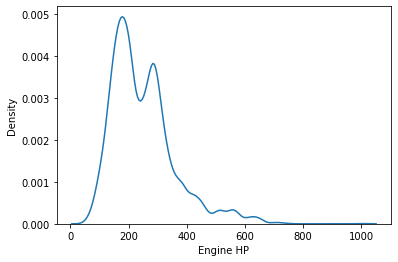

In [9]:
#Engine HP
#since Engine HP is a numeric column
#we can check distribution and fill columns from the graph

print(df['Engine HP'].mean())
print(df['Engine HP'].median())
print(df['Engine HP'].mode())
sns.kdeplot(df['Engine HP'])
#sns.boxplot(df['Engine HP'])

#I'm going to use median since the distribution is skewed and there are outliers so we cannot really use mean
#I would've probably used mode but !!! It just does'nt fell right to do so 🤔

df['Engine HP'].fillna(df['Engine HP'].median(), inplace = True)

<AxesSubplot:xlabel='Engine HP', ylabel='Density'>

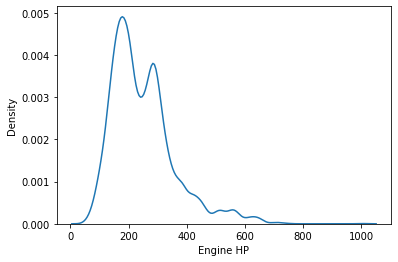

In [10]:
#New graph
sns.kdeplot(df['Engine HP'])    #mehh looks roughly thesame idk

5.628828677213059
6.0
0    4.0
Name: Engine Cylinders, dtype: float64


C:\Users\Gift\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Gift\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Engine Cylinders'>

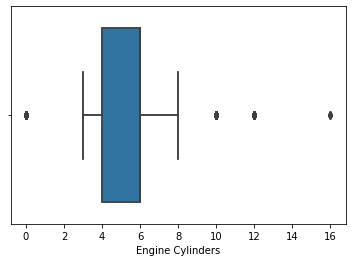

In [13]:
#Engine Cylinders
#using the same method

print(df['Engine Cylinders'].mean())
print(df['Engine Cylinders'].median())
print(df['Engine Cylinders'].mode())
sns.boxplot(df['Engine Cylinders'])

#im using mean.. dont ask why... 'cause I don't know (for now at least)
df['Engine Cylinders'].fillna(df['Engine Cylinders'].median(), inplace = True)

sns.boxplot(df['Engine Cylinders'])

In [14]:
#I dont really care about the number of doors just use ffill
df['Number of Doors'].fillna(method='ffill', inplace = True)


In [15]:
#Market Category
#this is a categorical column
lst = df['Market Category'].unique()
print(lst)

['Factory Tuner,Luxury,High-Performance' 'Luxury,Performance'
 'Luxury,High-Performance' 'Luxury' 'Performance' 'Flex Fuel'
 'Flex Fuel,Performance' nan 'Hatchback' 'Hatchback,Luxury,Performance'
 'Hatchback,Luxury' 'Luxury,High-Performance,Hybrid' 'Diesel,Luxury'
 'Hatchback,Performance' 'Hatchback,Factory Tuner,Performance'
 'High-Performance' 'Factory Tuner,High-Performance'
 'Exotic,High-Performance' 'Exotic,Factory Tuner,High-Performance'
 'Factory Tuner,Performance' 'Crossover' 'Exotic,Luxury'
 'Exotic,Luxury,High-Performance' 'Exotic,Luxury,Performance'
 'Factory Tuner,Luxury,Performance' 'Flex Fuel,Luxury' 'Crossover,Luxury'
 'Hatchback,Factory Tuner,Luxury,Performance' 'Crossover,Hatchback'
 'Hybrid' 'Luxury,Performance,Hybrid'
 'Crossover,Luxury,Performance,Hybrid' 'Crossover,Luxury,Performance'
 'Exotic,Factory Tuner,Luxury,High-Performance'
 'Flex Fuel,Luxury,High-Performance' 'Crossover,Flex Fuel' 'Diesel'
 'Hatchback,Diesel' 'Crossover,Luxury,Diesel'
 'Crossover,Luxury,Hi

OKAY THE COLUMN LABELS WERE TOO MUCH (AND ALMOST OVERWHELMING) SO I DECIDED TO CREATE A MODEL TO PREDICT THEM 

In [16]:
#butt i git the unique categories from the market category column
market_category_list = []
for i in lst:
    if isinstance(i, str):
        if ',' in i:
            new_list = i.split(',')
            for j in new_list:
                if j in market_category_list:
                    print(j, 'already found')
                    continue
                else:
                    market_category_list.append(j)
                    print(j, 'added')
        else:
            if i in market_category_list:
                print(i, 'already found')
                continue
            else:
                market_category_list.append(i)
                print(i, 'added')


Factory Tuner added
Luxury added
High-Performance added
Luxury already found
Performance added
Luxury already found
High-Performance already found
Luxury already found
Performance already found
Flex Fuel added
Flex Fuel already found
Performance already found
Hatchback added
Hatchback already found
Luxury already found
Performance already found
Hatchback already found
Luxury already found
Luxury already found
High-Performance already found
Hybrid added
Diesel added
Luxury already found
Hatchback already found
Performance already found
Hatchback already found
Factory Tuner already found
Performance already found
High-Performance already found
Factory Tuner already found
High-Performance already found
Exotic added
High-Performance already found
Exotic already found
Factory Tuner already found
High-Performance already found
Factory Tuner already found
Performance already found
Crossover added
Exotic already found
Luxury already found
Exotic already found
Luxury already found
High-Performa

In [17]:
market_category_list

['Factory Tuner',
 'Luxury',
 'High-Performance',
 'Performance',
 'Flex Fuel',
 'Hatchback',
 'Hybrid',
 'Diesel',
 'Exotic',
 'Crossover']

<AxesSubplot:ylabel='Market Category'>

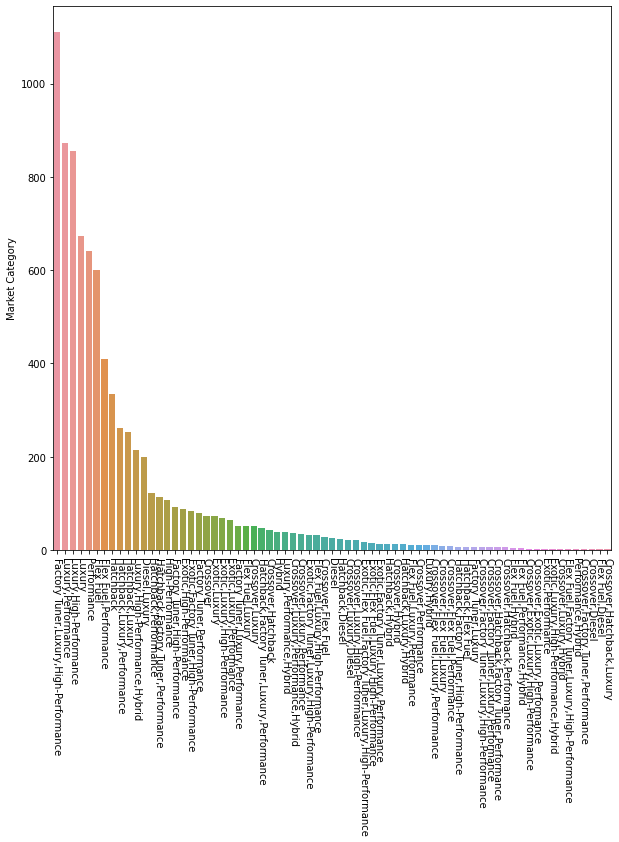

In [19]:
df.drop(df.index[df['Market Category'].isna()], inplace=True)
plt.figure(figsize=(10, 10))
plt.xticks(rotation=-90)
sns.barplot(x=df['Market Category'].unique(), y=df['Market Category'].value_counts())

#well from the graph the distribution of this data columns is skewed

Basic univariate analysis next

In [20]:
categorical_columns = ['Make', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']
numeric_columns = ['Year', 'Engine HP',  'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']

274.0753793441018
260.0
0    200.0
Name: Engine HP, dtype: float64


<AxesSubplot:xlabel='Engine HP', ylabel='Density'>

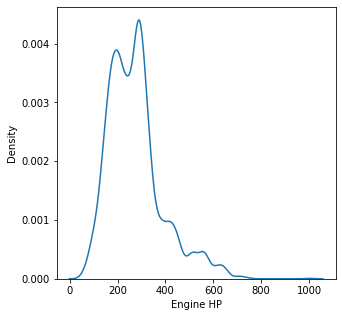

In [28]:
print(df['Engine HP'].mean())
print(df['Engine HP'].median())
print(df['Engine HP'].mode())

plt.figure(figsize=(5, 5))
sns.kdeplot(df['Engine HP'])


2012.076603034753
2015.0
0    2015
Name: Year, dtype: int64


C:\Users\Gift\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Year', ylabel='count'>

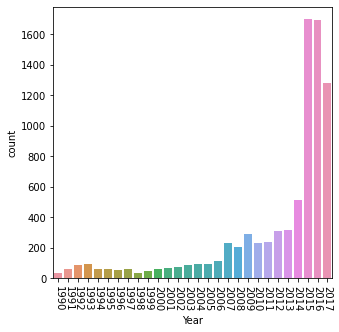

In [33]:
print(df['Year'].mean())
print(df['Year'].median())
print(df['Year'].mode())

plt.figure(figsize=(5, 5))
plt.xticks(rotation=-90)
sns.countplot(df['Year'])

#yeahh from this we can see that most cars were produced in 2015, 2016

27.072564855604504
26.0
0    24
Name: highway MPG, dtype: int64


C:\Users\Gift\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='highway MPG', ylabel='count'>

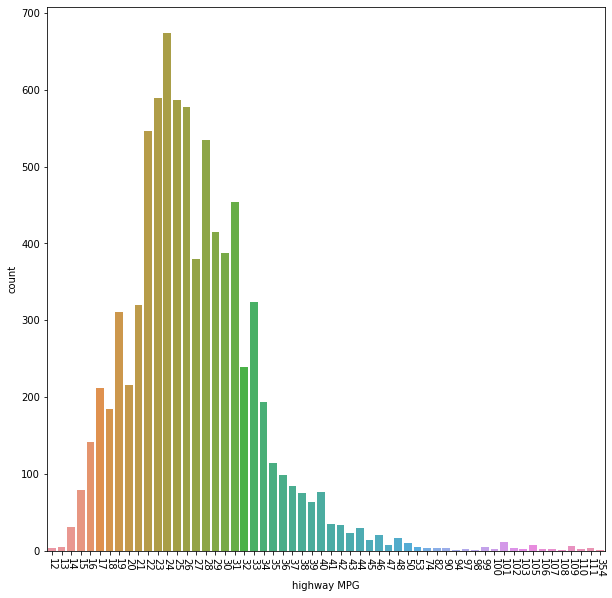

In [40]:
print(df['highway MPG'].mean())
print(df['highway MPG'].median())
print(df['highway MPG'].mode())

plt.figure(figsize=(10, 10))
plt.xticks(rotation=-90)
sns.countplot(df['highway MPG'])

#most cars have an avg highway MPG of 24 (I guess that's alright)

20.083578071463535
18.0
0    17
Name: city mpg, dtype: int64


C:\Users\Gift\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='city mpg', ylabel='count'>

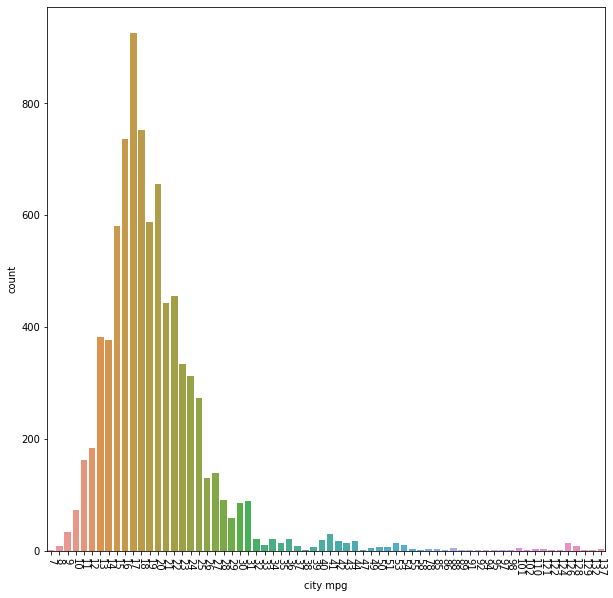

In [41]:
print(df['city mpg'].mean())
print(df['city mpg'].median())
print(df['city mpg'].mode())

plt.figure(figsize=(10, 10))
plt.xticks(rotation=-90)
sns.countplot(df['city mpg'])

#avg city mgp is 17 

We could analyse each column one by one but it seems unnecessary so I'll just do something else

car brand vs mpg
car brand vs price
car brand vs popularity
popularity vs price
engine fuel type vs engine hp
driven wheels vs engine hp